In [11]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import timm
import open_clip
import torch
torch.set_grad_enabled(False)
from PIL import Image
import cv2
import pickle

with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

model = timm.models.eva_giant_patch14_224(pretrained=True)
# model, _, preprocess = open_clip.create_model_and_transforms("EVA01-g-14", 'laion400m_s11b_b41k')
# model.cuda()
# model.eval()
# tokenizer = open_clip.get_tokenizer("EVA01-g-14")
# point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda']
# specific_views = list(set(point_feature_cameras) - {"sceneshotcam"})

model.safetensors:   0%|          | 0.00/4.05G [00:00<?, ?B/s]

In [19]:
scene_img = outputs["sceneshotcam"]
scene_img = cv2.resize(scene_img, (224, 224))
print(scene_img.shape)
global_feat = model.forward_features(torch.from_numpy(scene_img).permute(2,0,1).unsqueeze(0).float())
print(global_feat.shape)
# with torch.cuda.amp.autocast():
#     _img = preprocess(Image.fromarray(scene_img)).unsqueeze(0)
#     global_feat = model.encode_image(_img.cuda())

(224, 224, 3)
torch.Size([1, 257, 1408])


In [17]:
print(global_feat.shape)

torch.Size([1, 1000])


In [2]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import timm
import open_clip
import torch
torch.set_grad_enabled(False)
import psutil
from lavis.common.registry import registry
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import gc
import cv2

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
import pickle
with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

In [6]:
FEAT_DIM = None

def get_model(model_type: str):
    if model_type == "clip":
        model, _, preprocess = open_clip.create_model_and_transforms("ViT-H-14", "laion2b_s32b_b79k")
        model.cuda()
        model.eval()
        tokenizer = open_clip.get_tokenizer("ViT-H-14")
        return (model, preprocess, tokenizer)
    elif model_type == "blip":
        model, preprocess = open_clip.create_model_from_pretrained("EVA01-g-14", 'laion400m_s11b_b41k')
        tokenizer = open_clip.get_tokenizer("EVA01-g-14")
        return (model, preprocess, tokenizer)
    else:
        raise Exception("invalid model type requested")
    
def process(outputs, point_feature_cameras, model_type):
    vit = get_model(model_type)
    if model_type == "clip":
        global_feat, feat_per_obj, obj_sim_per_unit_area = process_with_clip(outputs, point_feature_cameras, vit)
    elif model_type == "blip":
        global_feat, feat_per_obj, obj_sim_per_unit_area = process_with_blip(outputs, point_feature_cameras, vit)
    else:
        raise Exception("invalid model type requested")
    return global_feat, feat_per_obj, obj_sim_per_unit_area, vit

# CLIP implementation
def process_with_clip(outputs, point_feature_cameras, vit):
    global FEAT_DIM

    model, preprocess, tokenizer = vit

    global_feat = None
    scene_img = outputs["sceneshotcam"]
    scene_img = cv2.resize(scene_img, (512, 512))
    with torch.cuda.amp.autocast():
        _img = preprocess(Image.fromarray(scene_img)).unsqueeze(0)
        imgfeat = model.encode_image(_img.cuda())  # [1, 1024]

    global_feat = imgfeat.half().cuda()

    global_feat = torch.nn.functional.normalize(global_feat, dim=-1)  # --> (1, 1024)
    FEAT_DIM = global_feat.shape[-1]

    cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
    specific_views = list(set(point_feature_cameras) - {"sceneshotcam"})
    feat_per_obj = []
    obj_sim_per_unit_area = []
    for view in tqdm(specific_views):
        # crop the image to the bounding box and run it through the visual encoder to get the feature vector for the object
        obj_img = outputs[view]
        roi = torch.ones((512, 512, 3))
        img_roi = torch.tensor(obj_img[:512,:512])
        roi[:img_roi.shape[0], :img_roi.shape[1]] = img_roi
        roi = roi.detach().cpu().numpy()
        img_roi = Image.fromarray(roi.astype('uint8'))
        img_roi = preprocess(img_roi).unsqueeze(0).cuda()
        roifeat = model.encode_image(img_roi).half().cuda()
        feat_per_obj.append(roifeat)

        # calculate the cosine similarity between the global feature vector and the feature vector for the object and save that as well
        _sim = cosine_similarity(global_feat, roifeat)
        obj_sim_per_unit_area.append(_sim)

        torch.cuda.empty_cache()

    return global_feat, feat_per_obj, obj_sim_per_unit_area

# BLIP implementation
def process_with_blip(outputs, point_feature_cameras, vit):
    global FEAT_DIM
    
    visual_encoder, preprocess, tokenizer = vit

    # calculate the global feature vector
    scene_img = outputs["sceneshotcam"]
    scene_img = cv2.resize(scene_img, (512, 512))
    with torch.cuda.amp.autocast():
        _img = preprocess(Image.fromarray(scene_img)).unsqueeze(0)
        global_feat = visual_encoder.encode_image(_img.cuda().float())  # [1, 14something]
    # scene_tensor = torch.tensor(scene_img[:512,:512]).permute(2, 0, 1)
    print(global_feat.shape)
    # use GPU for this
    # scene_tensor = scene_tensor.unsqueeze(0).float().to(gpu_device)
    # global_feat = visual_encoder(scene_tensor)
    global_feat = global_feat.half()
    global_feat = global_feat.mean(1)
    print(global_feat.shape)
    # global_feat = torch.nn.functional.normalize(global_feat, dim=-1)
    # FEAT_DIM = global_feat.shape[-1]

    # specific_views = list(set(point_feature_cameras) - {"sceneshotcam"})
    # feat_per_obj = []
    # obj_sim_per_unit_area = []
    # for view in tqdm(specific_views):
    #     # crop the image to the bounding box and run it through the visual encoder to get the feature vector for the object
    #     obj_img = outputs[view]
    #     roi = torch.ones((512, 512, 3))
    #     img_roi = torch.tensor(obj_img[:512,:512])
    #     roi[:img_roi.shape[0], :img_roi.shape[1]] = img_roi
    #     img_roi = roi.permute(2, 0, 1).unsqueeze(0).to(gpu_device)
    #     roifeat = visual_encoder(img_roi)
    #     roifeat = roifeat.half().cuda()
    #     roifeat = roifeat.mean(1)
    #     roifeat = torch.nn.functional.normalize(roifeat, dim=-1)
    #     feat_per_obj.append(roifeat)

    #     # calculate the cosine similarity between the global feature vector and the feature vector for the object and save that as well
    #     _sim = cosine_similarity(global_feat, roifeat)
    #     obj_sim_per_unit_area.append(_sim)

    #     torch.cuda.empty_cache()

    # return global_feat, feat_per_obj, obj_sim_per_unit_area

    return None, None, None

In [7]:
# get features and similarity scores for the objects
point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'ur5e', 'panda']
specific_views = list(set(point_feature_cameras) - {"sceneshotcam"})
global_feat, feat_per_obj, obj_sim_per_unit_area, vit = process(outputs, point_feature_cameras, "blip")

RuntimeError: Input type (c10::Half) and bias type (float) should be the same

In [5]:
# get the data for the pointcloud, and initialize the pixelwise features
xyz_pts = outputs['xyz_pts']
segmentation_pts = outputs['segmentation_pts']
rgb_pts = outputs['rgb_pts']
pixelwise_features = global_feat.repeat((xyz_pts.shape[0], 1))#torch.zeros(xyz_pts.shape[0], FEAT_DIM, dtype=torch.half)
print(pixelwise_features.shape, xyz_pts.shape)

torch.Size([1041540, 1408]) (1041540, 3)


In [6]:
scores = torch.cat(obj_sim_per_unit_area).to(gpu_device)
feat_per_obj = torch.cat(feat_per_obj, dim=0).to(gpu_device)

# get the cosine simixlarity between the features of each object. This will be a square matrix where the (i, j)th entry is the cosine similarity between the ith and jth objects
mask_sim_mat = torch.nn.functional.cosine_similarity(
    feat_per_obj[:, :, None], feat_per_obj.t()[None, :, :]
)
print(specific_views)
print(mask_sim_mat)
mask_sim_mat.fill_diagonal_(0.0) # set the diagonal to 0 because we don't want to consider the similarity between the same object
mask_sim_mat = mask_sim_mat.mean(1)  # avg sim of each mask with each other mask
softmax_scores = scores.cuda() - mask_sim_mat # subtracting the object-object relevance (which can be thought of as the relevance of the object in context of the other objects) object-scene similarity (which is kind of like global relevance) gives how much more or less important that object is than all the other objects
softmax_scores = torch.nn.functional.softmax(softmax_scores, dim=0) # apply softmax to get the final scores
print(softmax_scores)

['bread', 'banana', 'bin', 'cereal', 'ur5e', 'panda', 'milk', 'apple']
tensor([[1.0000, 0.9814, 0.9868, 0.9839, 0.9658, 0.9746, 0.9912, 0.9893],
        [0.9814, 0.9995, 0.9854, 0.9590, 0.9526, 0.9644, 0.9878, 0.9771],
        [0.9868, 0.9854, 1.0000, 0.9692, 0.9624, 0.9717, 0.9917, 0.9819],
        [0.9839, 0.9590, 0.9692, 0.9995, 0.9458, 0.9551, 0.9766, 0.9790],
        [0.9658, 0.9526, 0.9624, 0.9458, 1.0010, 0.9829, 0.9648, 0.9727],
        [0.9746, 0.9644, 0.9717, 0.9551, 0.9829, 0.9995, 0.9731, 0.9780],
        [0.9912, 0.9878, 0.9917, 0.9766, 0.9648, 0.9731, 0.9995, 0.9878],
        [0.9893, 0.9771, 0.9819, 0.9790, 0.9727, 0.9780, 0.9878, 1.0000]],
       device='cuda:0', dtype=torch.float16)
tensor([0.1243, 0.1247, 0.1252, 0.1224, 0.1270, 0.1265, 0.1247, 0.1252],
       device='cuda:0', dtype=torch.float16)


In [7]:
# populate the pixelwise features with the computed embeddings
pixelwise_features = pixelwise_features.to(gpu_device)
for objidx in range(len(specific_views)):
    _weighted_feat = (
        softmax_scores[objidx] * global_feat + (1 - softmax_scores[objidx]) * feat_per_obj[objidx]
    )
    _weighted_feat = torch.nn.functional.normalize(_weighted_feat, dim=-1)
    pixelwise_features[segmentation_pts[specific_views[objidx]], :] = _weighted_feat.half()

In [8]:
# pixelwise_features = pixelwise_features.to(cpu_device).unsqueeze(0)
# xyz_pts = torch.tensor(xyz_pts).to(cpu_device).long().unsqueeze(0)
# torch.save(pixelwise_features, 'pixelwise_features.pt')
# torch.save(xyz_pts, 'xyz_pts.pt')

In [13]:
def compute_sim(text, vit, model_type):
    if model_type == "clip":
        return compute_sim_clip(text, vit)
    elif model_type == "blip":
        return compute_sim_blip(text, vit)
    else:
        raise Exception("invalid model type requested")

# get text semantics - clip approach
def compute_sim_clip(text, vit):
    model, _, tokenizer = vit
    text = tokenizer([text])
    textfeat = model.encode_text(text.cuda())
    textfeat = torch.nn.functional.normalize(textfeat, dim=-1)
    textfeat = textfeat.unsqueeze(0)

    map_embeddings_norm = torch.nn.functional.normalize(pixelwise_features, dim=1)
    cosine_similarity = torch.nn.CosineSimilarity(dim=-1).to('cuda')

    # calculate the similarity between all of the pixel-level embeddings and the prompt, and scale it to the [0,1] range (normally [-1,1]) to serve as a colormap weight
    similarity = cosine_similarity(
        map_embeddings_norm, textfeat
    )

    similarity_shifted = (similarity + 1.0) / 2.0 # shift the similarity to the [0,1] range

    similarity_rel = (similarity_shifted - similarity_shifted.min()) / (
                    similarity_shifted.max() - similarity_shifted.min() + 1e-12
                ) # normalize the similarity to the [0,1] range

    similarity_rel_thresholded = similarity_rel.clone()
    similarity_rel_thresholded[similarity_rel_thresholded < 0.6] = 0.0

    return similarity_rel_thresholded[0].detach().numpy()

# get text semantics - blip approach
def compute_sim_blip(text, vit):
    raise NotImplementedError("BLIP does not support text embeddings")

/var/tmp/ipykernel_129877/2002486168.py:21: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
/var/tmp/ipykernel_129877/2002486168.py:22: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
/var/tmp/ipykernel_129877/2002486168.py:23: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore


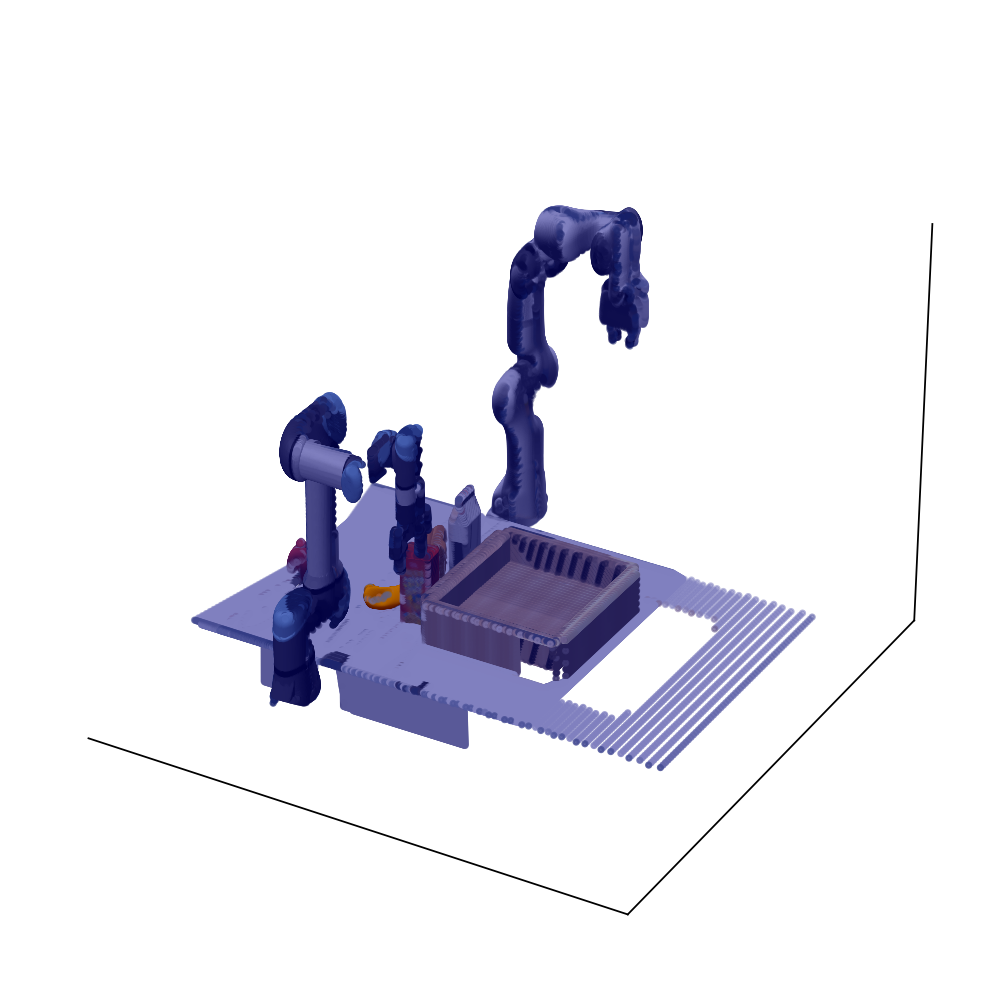

In [68]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

similarity = compute_sim("a banana", pixelwise_features, vit, "clip")

fig = plt.figure(figsize=(6, 6), dpi=160)
ax = fig.add_subplot(111, projection="3d")

x, y, z = (
    xyz_pts[:, 0],
    xyz_pts[:, 1],
    xyz_pts[:, 2],
)

cmap = colormaps.get_cmap('jet')
similarity_colormap = cmap(similarity)[:, :3]

rgb_pts = outputs['rgb_pts'].astype(float)/255.0
plot_colors = rgb_pts * 0.5 + similarity_colormap * 0.5

ax.set_facecolor((1.0, 1.0, 1.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0))  # type: ignore

ax.scatter(
    x,
    y,
    z,
    c=plot_colors,
    s=5,  # type: ignore
)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])  # type: ignore

plt.tight_layout(pad=0)
plt.show()
plt.close(fig)